# Анализ бизнес показателей развлекательного приложения

<h3> Бриф <a class="tocSkip"></h2>

Вы — маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. 

<h3> Цель исследования <a class="tocSkip"></h2>

разобраться в причинах неэффективности рекламных кампаний и помочь компании выйти в плюс.

<h3> План работы <a class="tocSkip"></h2>

1. Входные данные — визиты, заказы, расходы
2. Предобработка данных
3. Исследовательский анализ данных
4. Рассчет маркетинговых показателей
5. Оценка окупаемости рекламы
6. Общий вывод

### Обзор данных

In [1]:
# загрузка библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

In [2]:
# чтение файлов
visits = pd.read_csv('visits_info_short.csv')
orders = pd.read_csv('orders_info_short.csv')
costs = pd.read_csv('costs_info_short.csv')

In [3]:
display(visits.head())
display(orders.head())
costs.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [4]:
display(visits.info())
display(orders.info())
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


**Промежуточный вывод**

При осмотре данных были выявлены следующие моменты:
1. Названия столбцов начинаются с заглавной буквы
2. Столбцы с датами не обладают соответствующим типом данных
3. Пропусков нет.

### Предобработка данных

In [5]:
# змейка
visits = visits.rename(columns={
        'User Id': 'User_Id',
        'Session Start': 'Session_Start',
        'Session End': 'Session_End'
})
orders = orders.rename(columns={
        'User Id': 'User_Id',
        'Event Dt': 'Event_Dt'
})
# приведем названия столбцов к нижнему регистру
df = [visits, orders, costs]
for table in df:
    table.columns = table.columns.str.lower()
    print(table.columns)

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')
Index(['user_id', 'event_dt', 'revenue'], dtype='object')
Index(['dt', 'channel', 'costs'], dtype='object')


In [6]:
# меняем тип данных
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt'])
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [7]:
# проверка на дубликаты
for table in df:
    print(table.duplicated().sum())

0
0
0


####

### Задаем функции

**Функция get_profiles()**

In [8]:
# задаем функцию get_profiles()

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'], format="%Y-%m-%d")
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

**Функция get_retention()**

In [9]:
# задаем функцию get_retention()

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

**Функция get_conversion()**

In [10]:
# задаем функцию get_conversion()

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

**Функция get_ltv()**

In [11]:
# задаем функцию get_ltv()

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

**Функция filter_data()**

In [12]:
# задаем функцию filter_data()

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

**Функция plot_retention()**

In [13]:
# задаем функцию plot_retention()

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

**Функция plot_conversion()**

In [14]:
# задаем функцию plot_conversion()

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

**Функция plot_ltv_roi()**

In [15]:
# задаем функцию plot_ltv_roi()

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

**Профили пользователей**

In [16]:
# составляем профили пользователей
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [17]:
# минимальная и максимальная даты привлечения пользователей
acq_date_min = profiles.dt.min()
observation_date = datetime(2019, 11, 1).date()
acq_date_min, observation_date

(Timestamp('2019-05-01 00:00:00'), datetime.date(2019, 11, 1))

Минимальная дата привлечения клиентов 5 мая 2019 года, момент анализа 1 ноября 2019

In [18]:
def agg_table(col):
    profiles['payer'] =  profiles['user_id'].isin(orders['user_id'])
    leaders =  profiles.groupby(col).agg({'user_id': 'nunique', 'payer': 'sum'})
    leaders['payers_share'] = round(leaders['payer'] / leaders['user_id'] * 100, 2)
    return leaders.sort_values('payers_share', ascending=False)

In [19]:
# страны-лидеры по привлеченным пользователям
agg_table('region')

,user_id,payer,payers_share
region,,,
United States,100002,6902,6.90
Germany,14981,616,4.11
UK,17575,700,3.98
France,17450,663,3.80


Лидер по привлеченным пользователям - США, во многом поэтому бОльшая часть платящих клиентов находится именно там. Далее идет Великобритания, Франция, минимум занимает Германия.

In [20]:
# устройства-лидеры по привлеченным пользователям
agg_table('device')

,user_id,payer,payers_share
device,,,
Mac,30042,1912,6.36
iPhone,54479,3382,6.21
Android,35032,2050,5.85
PC,30455,1537,5.05


Большое всего платящих клиентов приходит с устройств на ios, лидер Mac, далее iPhone.

Узнаем какие устройства лидируют в каких странах

In [21]:
def lead_device(profile):
    plt.figure(figsize=(10, 7))
    
    ax1 = plt.subplot(2, 2, 1)
    
    (
    profile.query('payer == True & region == "United States"')
           .groupby('device').agg({'user_id': 'nunique'})
           .plot(kind='pie', subplots=True, legend=None, autopct='%1.0f%%', ax=ax1))
    
    plt.title('Доли устройств на американском рынке' + '\n')

    ax2 = plt.subplot(2, 2, 2)
    
    (
    profile.query('payer == True & region == "Germany"')
           .groupby('device').agg({'user_id': 'nunique'})
           .plot(kind='pie', subplots=True, legend=None, autopct='%1.0f%%', ax=ax2))
    
    plt.title('Доли устройств на немецком рынке' + '\n')
    
    ax3 = plt.subplot(2, 2, 3)
    
    (
    profile.query('payer == True & region == "UK"')
           .groupby('device').agg({'user_id': 'nunique'})
           .plot(kind='pie', subplots=True, legend=None, autopct='%1.0f%%', ax=ax3))
    
    plt.title('Доли устройств на британском рынке' + '\n')
    
    ax4 = plt.subplot(2, 2, 4)
    
    (
    profile.query('payer == True & region == "France"')
           .groupby('device').agg({'user_id': 'nunique'})
           .plot(kind='pie', subplots=True, legend=None, autopct='%1.0f%%', ax=ax4))
    
    plt.title('Доли устройств на французском рынке' + '\n')
    ;

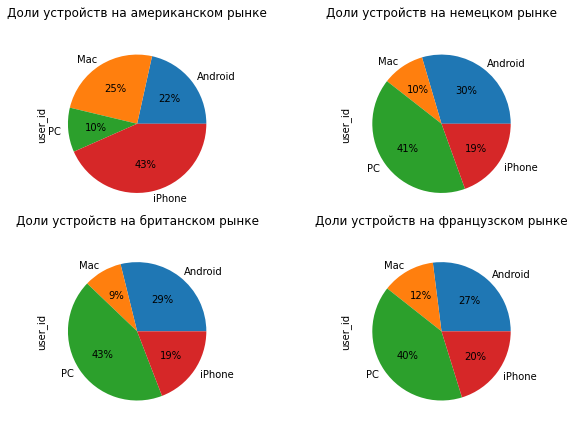

In [22]:
lead_device(profiles)

Видим, что 43% американских платящих пользователей используют iPhone как основное устройство. По сравнению с европейским рынком устройства Apple действительно лидируют в Америке.

На остальных рынках лидирует именно PC. В европейских странах распределение устройств по пользователям очень схожее, от страны к стране доли отличаются на несколько процентов.

In [23]:
# источники-лидеры по привлеченным пользователям
agg_table('channel')

,user_id,payer,payers_share
channel,,,
FaceBoom,29144,3557,12.20
AdNonSense,3880,440,11.34
lambdaMediaAds,2149,225,10.47
TipTop,19561,1878,9.60
RocketSuperAds,4448,352,7.91
WahooNetBanner,8553,453,5.30
YRabbit,4312,165,3.83
MediaTornado,4364,156,3.57
LeapBob,8553,262,3.06


Платформы-лидеры по количеству привлеченных платящих клиентов: FaceBoom, AdNonSense, lambdaMediaAds.

Интересно, что органический трафик приносит значительную долю пользователей, в том числе и платящих, значит конверсия есть. Естественный трафик - это несомненный плюс, он стабилен и бесплатен)

### Маркетинговый анализ

In [24]:
# общая сумма расходов на маркетинг
total_cost = round(costs.costs.sum())
total_cost

105497

In [25]:
# распределение рекламного бюджета по источникам трафика
budget_costs = costs.groupby('channel').agg({'costs': 'sum'}).sort_values('costs', ascending=False)
budget_costs['share'] = round(budget_costs['costs'] / total_cost, 2)
budget_costs

,costs,share
channel,,
TipTop,54751.30,0.52
FaceBoom,32445.60,0.31
WahooNetBanner,5151.00,0.05
AdNonSense,3911.25,0.04
OppleCreativeMedia,2151.25,0.02
RocketSuperAds,1833.00,0.02
LeapBob,1797.60,0.02
lambdaMediaAds,1557.60,0.01
MediaTornado,954.48,0.01


Больше всего бюджета было потрачено на TipTop (52%), FaceBoom (31%), WahooNetBanner (5%)

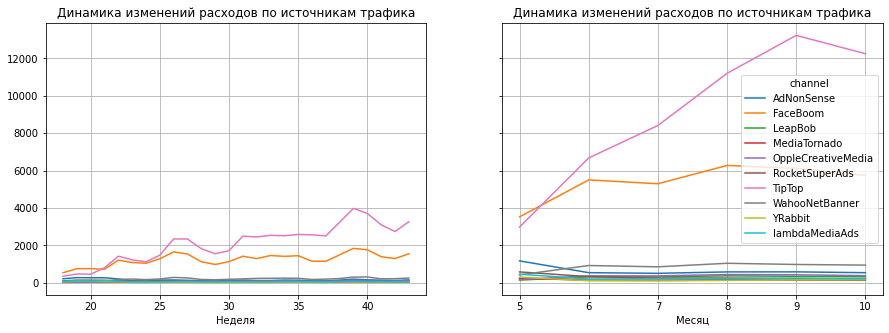

In [26]:
costs['costs_week'] = costs['dt'].dt.isocalendar().week
costs['costs_month'] = costs['dt'].dt.month

plt.figure(figsize=(15, 5))

ax1 = plt.subplot(1, 2, 1)

costs.pivot_table(index='costs_week', columns='channel', values='costs', aggfunc='sum'
                ).plot(grid=True, ax=ax1, legend=None)
plt.title('Динамика изменений расходов по источникам трафика')
plt.xlabel('Неделя')

ax2 = plt.subplot(1, 2, 2, sharey=ax1)

costs.pivot_table(index='costs_month', columns='channel', values='costs', aggfunc='sum'
                ).plot(grid=True, ax=ax2)

plt.title('Динамика изменений расходов по источникам трафика')
plt.xlabel('Месяц')
plt.show();

Видим, что за все месяцы максимальные суммы затрат выделялись на 2 источника: TipTop и FaceBoom. На остальные выделялись примерно равные бюджеты.

In [27]:
# cac каждого источника трафика
cac_channels = pd.DataFrame()
cac_channels['acquisition_cost_mean'] = round(profiles.query('channel != "organic"')
                                                 .groupby('channel')['acquisition_cost'].mean()
                                                 .sort_values(ascending=False), 2)
cac_channels

,acquisition_cost_mean
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


Самые дорогие пользователи были привлечены источником TipTop (2.8), у FaceBoom и AdNonSense привлечение одного пользователя стоит примерно одинакого (около рубля). Минимальный CAC у LeapBob - 0.21

Посмотрим на среднюю стоимость привлечения пользователя по всему проекту

In [28]:
round(profiles.query('channel != "organic"')['acquisition_cost'].mean(), 2)

1.13

Средний САС равен 1.13, получается, что стоимость привлечения клиента через TipTop превышает средний CAC более чем в 2 раза. В свою очередь у FaceBoom и AdNonSense CAC ниже, чем средний.

### Оценка окупаемости рекламы

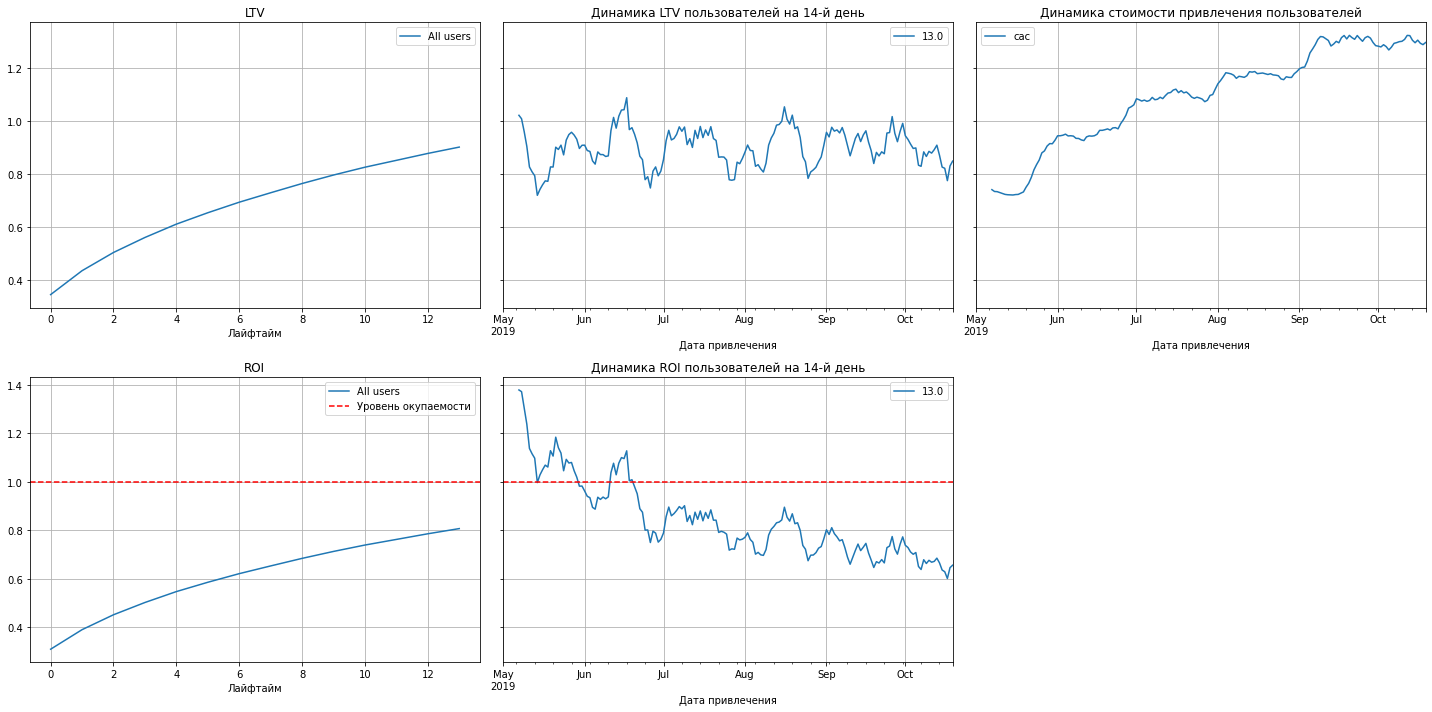

In [29]:
horizon_days=14
window=7

profiles_fil = profiles.query('channel != "organic"')

ltv_raw, ltv, ltv_dynamics, roi, roi_dynamics = get_ltv(
    profiles_fil, orders, observation_date, horizon_days
)

plot_ltv_roi(
    ltv, ltv_dynamics, roi, roi_dynamics, horizon_days, window
)

Исходя из графиков можно сделать следующие выводы:

1. Динамика LTV на 14 день показывает, что колебания показателя одинаковы
2. CAC резко поднялась в июне и далее постоянно увеличивалась
3. Реклама не окупается, это мы видим на графике ROI
4. Сопоставляя графики динамики CAC и динамики ROI на 14-й день, можно заметить, что с увеличением затрат на привлечение пользователей в мае их окупаемость начала стремительно уменьшаться
5. До июня рекламные компании окупались

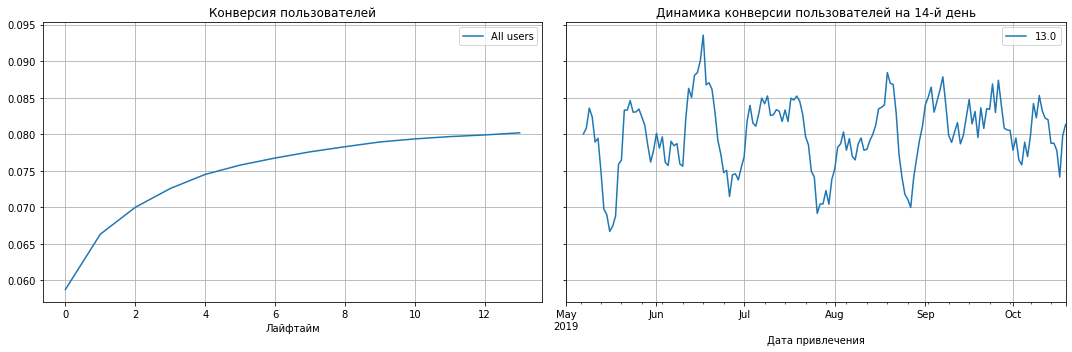

In [30]:
conversion_raw, conversion, conversion_dynamics = get_conversion(
    profiles_fil, orders, observation_date, horizon_days
)
plot_conversion(
    conversion, conversion_dynamics, horizon_days, window
)

По показателям конверсии по всем пользователям нельзя сделать конкретные выводы. Посмотрим конверсию по устройствам.

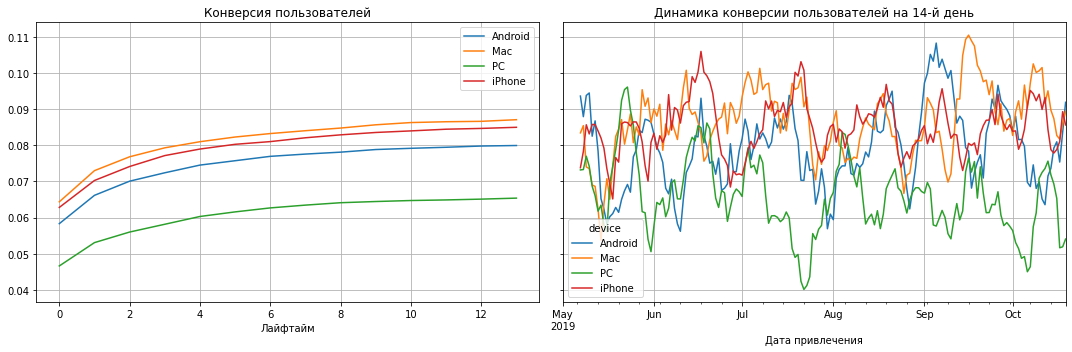

In [31]:
dimensions = ['device']

conversion_raw, conversion, conversion_dynamics = get_conversion(
    profiles_fil, orders, observation_date, horizon_days, dimensions=dimensions
)
plot_conversion(
    conversion, conversion_dynamics, horizon_days, window
)

Лучшая конверсия у пользователей Mac, худшая же у PC

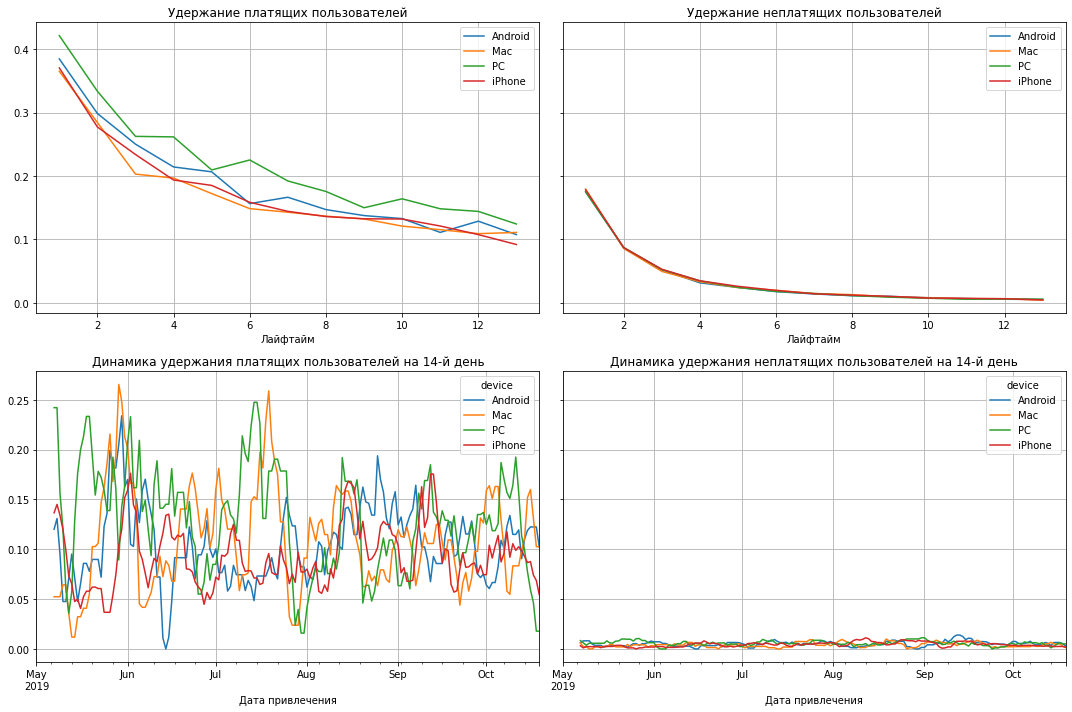

In [32]:
retention_raw, retention, retention_dynamics = get_retention(
    profiles_fil, visits, observation_date, horizon_days, dimensions=dimensions
)
plot_retention(
    retention, retention_dynamics, horizon_days, window
)

Несмотря на худшую конверсию пользователей с PC, платящие пользователи лучше всего удерживаются, в то время как клиенты на Mac наоборот удерживаются хуже всех.

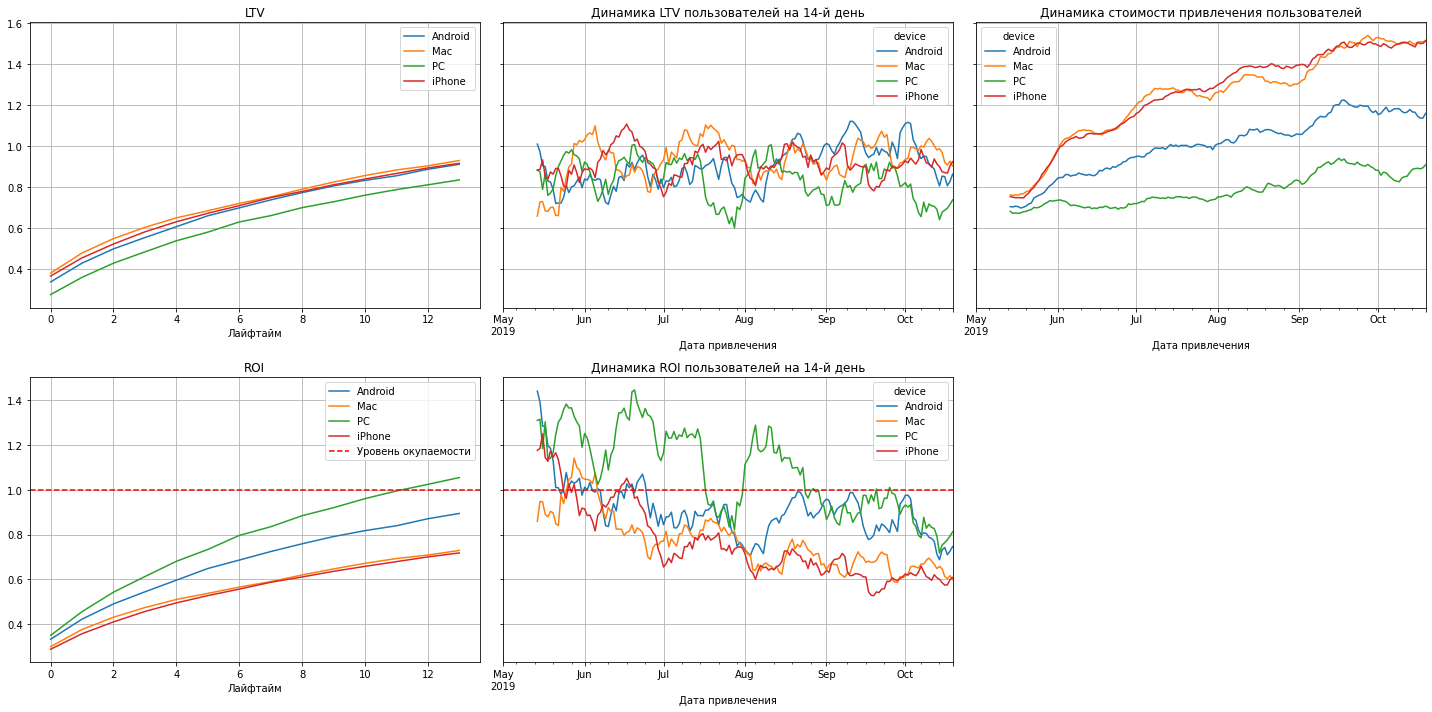

In [33]:
# графики окупаемости рекламы с разбивкой по устройствам

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_fil, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Стоимость привлечения пользователей с iPhone и Mac увеличивается, но вложения в них не окупаются. 

По графику динамики стоимости привлечения видно, что компания начала увеличивать бюджеты в рекламу с июня. 

Динамика ROI показывает, что реклама окупается только на PC. 

LTV стабилен для всех устройств, но LTV PC меньше, чем остальных устройств.

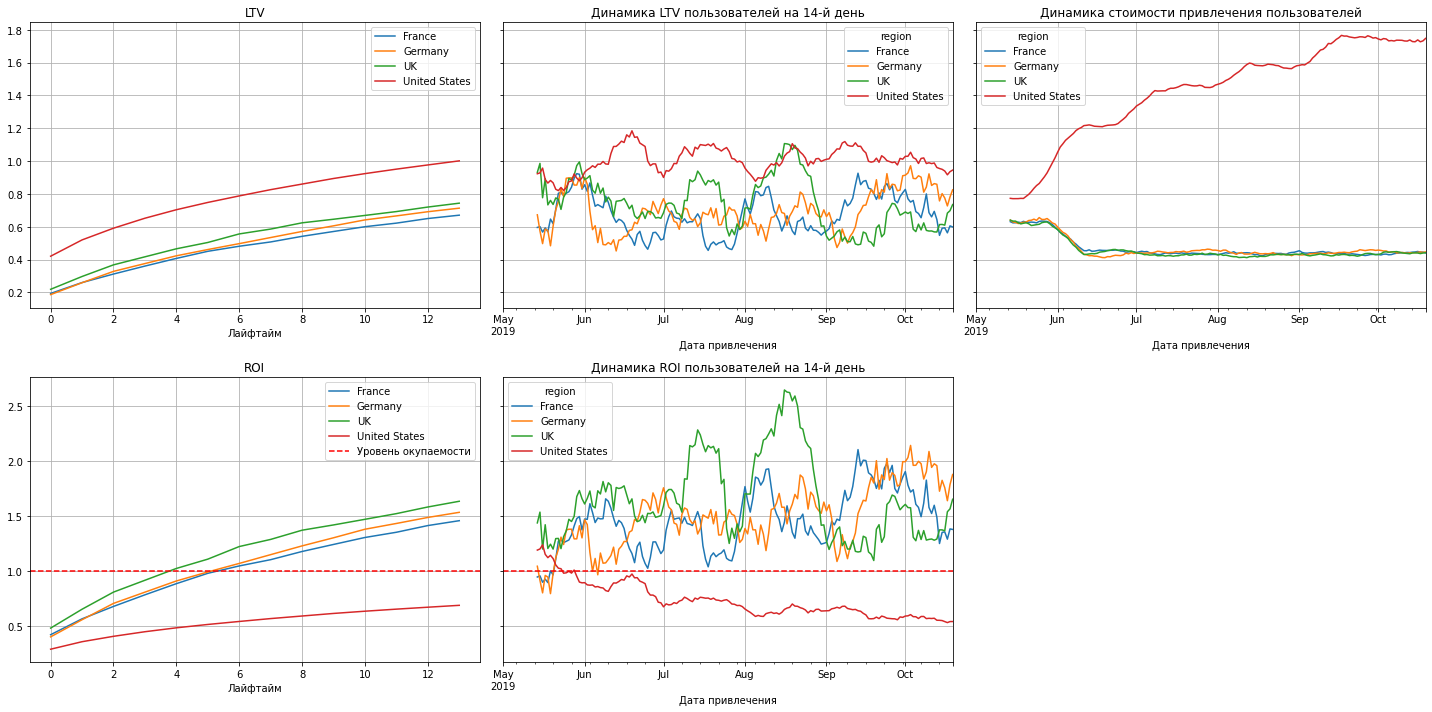

In [34]:
# графики окупаемости рекламы с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_fil, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Прибыль, полученная от пользователей США, почти в два раза выше, чем от пользователей других стран. 

Исходя из разбивки по странам, бросается в глаза, что большая часть бюджета направлена на продвижение на американском рынке, но вложений настолько много, что они не могут или не успевают окупиться.

Лучше всего окупается конечно Великобритания, а затем Германия и Франция.

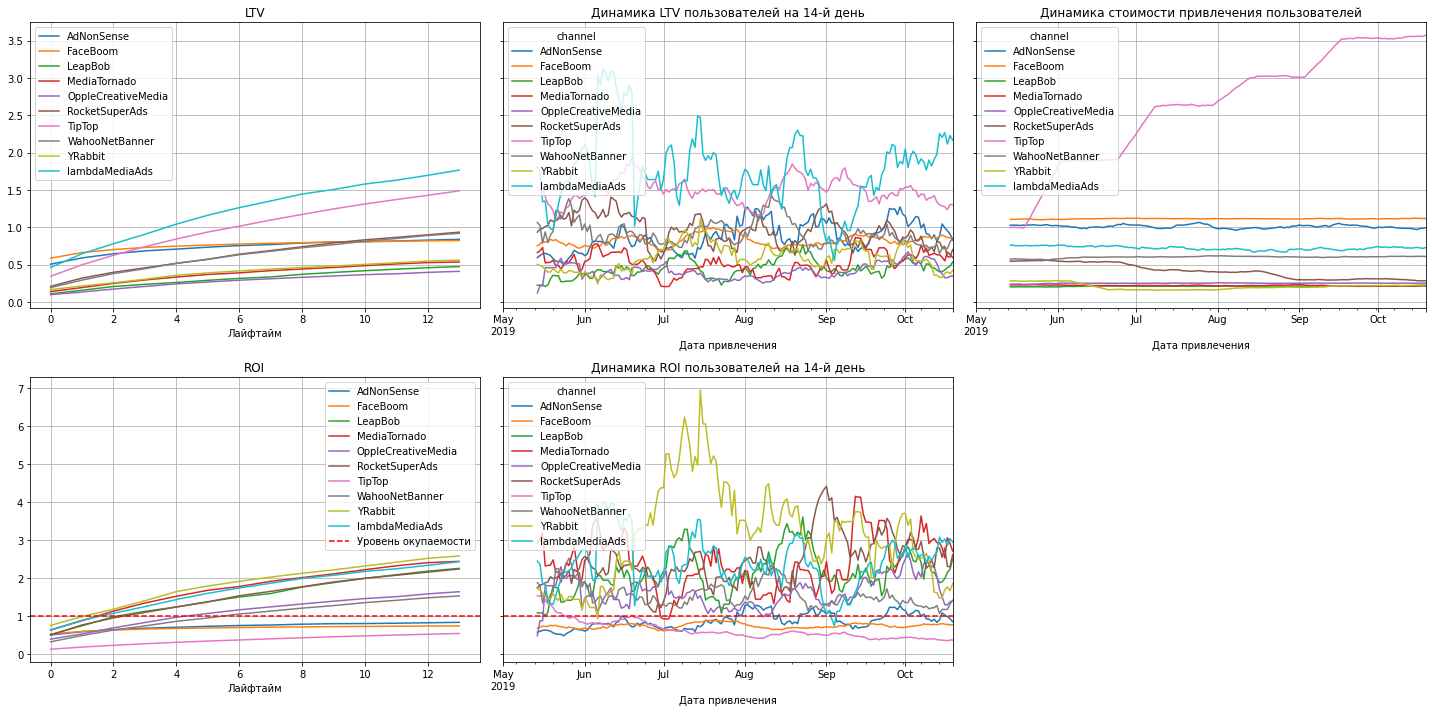

In [35]:
# графики окупаемости рекламы с разбивкой по каналам

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_fil, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Из всех каналов продвижения больше всего выделяется TipTop: CAC не стабилен, на его графике можно увидеть пороги, возможно в конде каждого месяца команда принимала решение повысить объемы закупаемого трафика.

Также в принципе не окупаются еще два канала: AdNonSense и FaceBoom.

Но можно выделить платформы lambdaMediaAds, YRabbit, MediaTornado, которые показывают хорошую окупаемость.

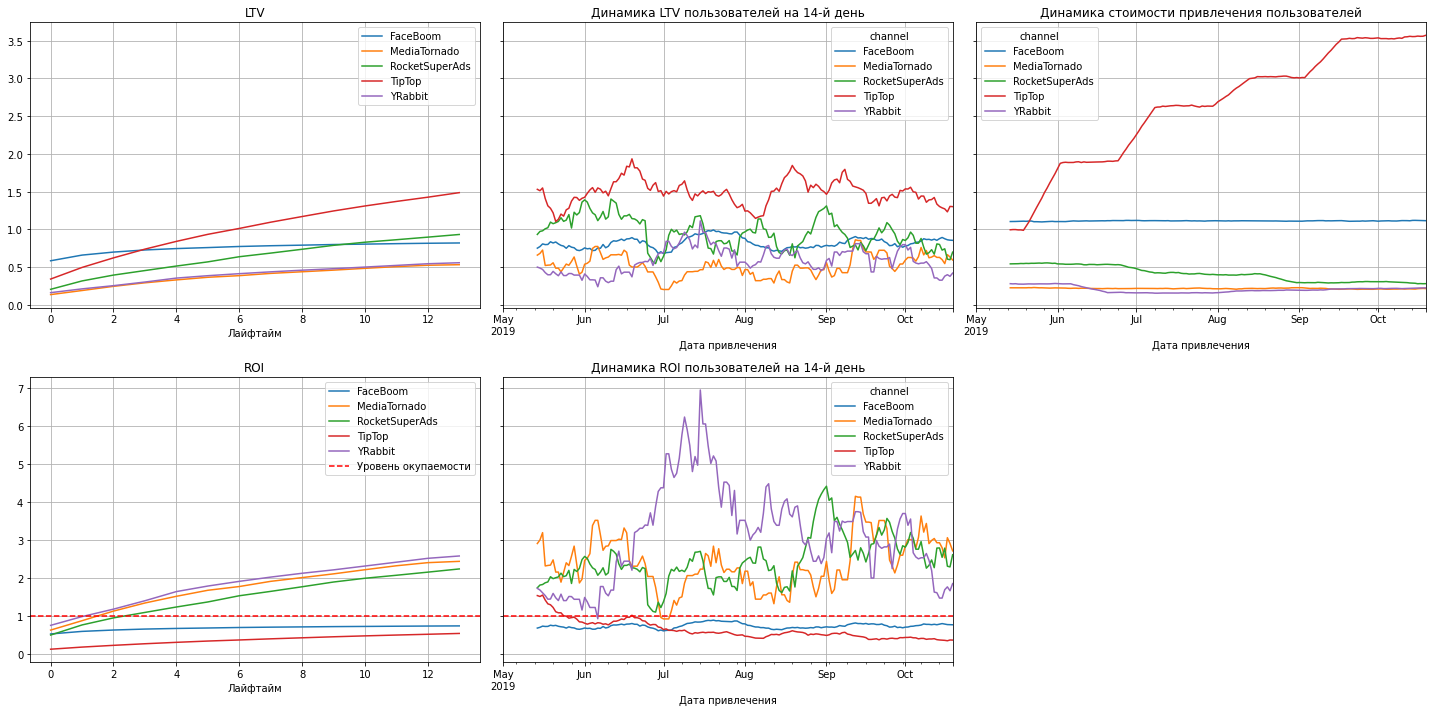

In [36]:
# посмотрим отдельно на окупаемость рекламы в США

profile_usa = profiles.query('channel != "organic" and region == "United States"')

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profile_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

На американском рынке не окупаются платформы также FaceBoom и TipTop

Посмотрим на окупаемость реклаы на устройствах Apple в США

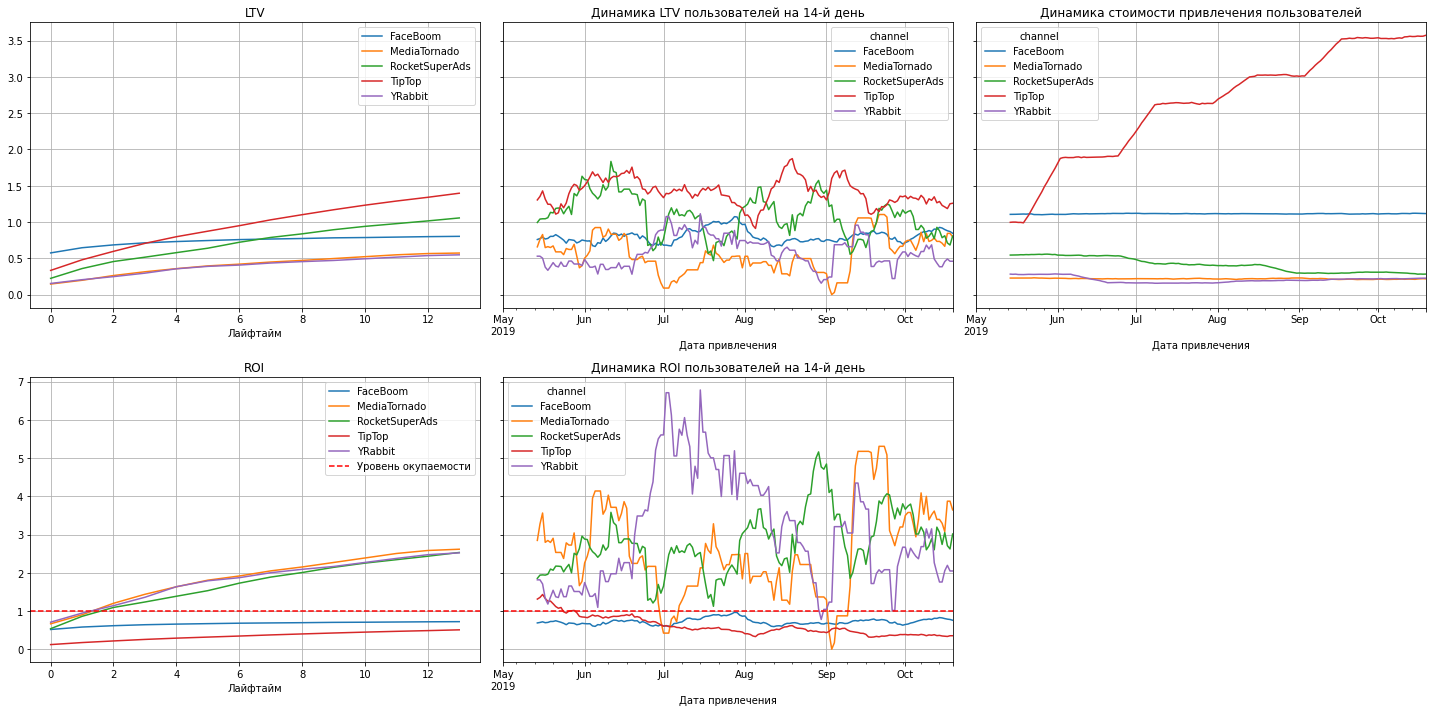

In [37]:
# посмотрим отдельно на окупаемость рекламы на устройствах Apple 

profile_ios = profiles.query('channel != "organic" and device == ["iPhone", "Mac"] and region == "United States"')

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profile_ios, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

На графики ROI можем увидеть платформы, ориентированные на ios-устройства. Из них видны те, которые не окупаются именно на ios: все те же TipTop и FaceBoom.

Теперь посмотрим на окупаемость рекламы в европейских странах

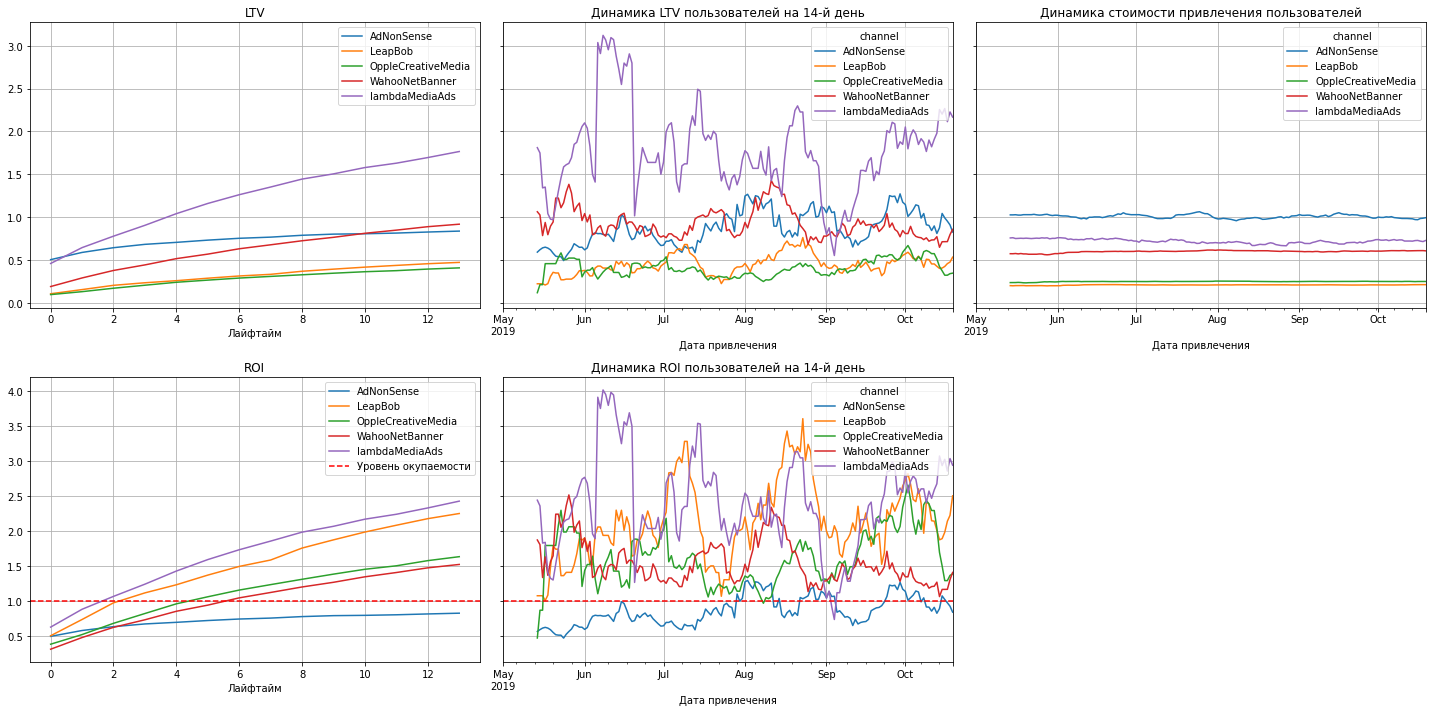

In [38]:
# посмотрим на поставщиков трафика в европе
profile_eu = profiles.query('channel != "organic" and region == ["UK", "Germany", "France"]')

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profile_eu, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Видно, что из всех постравщиков трафика не окупается только одна - AdNonSense

Также из устройств не окупается Android. Посмотрим на платформы, выставляющие рекламу на android-устройствах

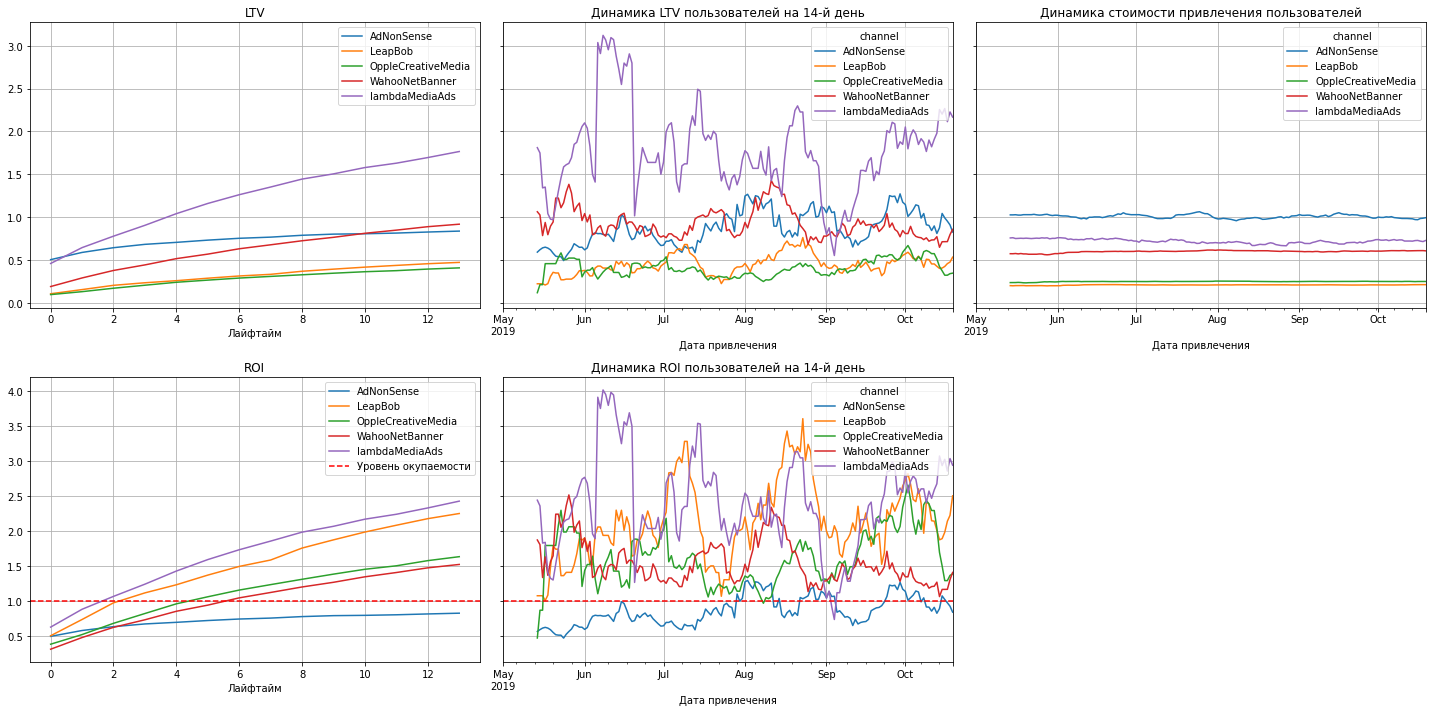

In [39]:
profile_and = profiles.query('channel != "organic" and region == ["UK", "Germany", "France"]')

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profile_and, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Промежутный вывод**

1. Можно сказать, что реклама, направленная на привлечение пользователей (и платящих и не платящих) не окупается, что можно увидеть на графиках ROI
2. Из разбивок по устройствам, странам и каналам можно выделить те, что негативно влияют на окупаемость рекламы.
    * Из устройств не окупаются iPhone и Mac. 
    * Вложения в американских пользователей превышают бюджеты других стран и также не окупаются. 
    * Следует пересмотреть пропорции рекламных бюджетов в различные каналы продвижения, особое внимание обратить на  TipTop, AdNonSense и FaceBoom, ведь они показывают худшую окупаемость.
3. Проблемы окупаемости могут быть вызваны несколькими причинами.
    * Самое банальное: затраты превышают потенциальные объемы привлечения
    * Не проведенный анализ рынка. Компания тратит деньги условно на продвижение приложения в той стране, где культурно оно не может заинтересовать много пользователей.
    * Нерациональное распределение рекламного бюджета. Канал TipTop несколько месяцев не показывал окупаемость, но компания продолжала не только вкладывать в него деньги, но и увеличивать вложения.

Возможно стоит уменьшить бюджет на некоторые каналы продвижения, позиционировать приложение главным образом не на США, где вложения не окупаются.

####

### Выводы

Причины неэффективности привлечения пользователей.

Рекламная стратегия приложения Procrastinate Pro+ нацелена на американский рынок, т.е. большая часть вложений направлена на привлечения пользователей в США. Вложения не окупаются, возможно американским пользователям не по вкусу продукт Procrastinate Pro+.

На рекламные каналы TipTop, AdNonSense и FaceBoom тратилось бюджета больше, чем на остальные каналы, но они не окупались. Может быть эти платформы не поставляют качественный трафик или ориентируются именно на американских пользователей, что вместе не приводит к окупаемости.

Рекомендации для отдела маркетинга.
* Требуется перераспределение средств и оптимизация бюджета на рекламные платформы. Не увеличивать бюджет там, где он не окупается.
* Большинство пользователей из США, и там реклама не окупается на FaceBoom и TipTop. В люом случае  нужно сокращать бюджет на эти платформы.
* Следует расширить количество рекламных платформ, ориентированных на Европу и исключить/ уменьшить бюджет на платформу AdNonSense.
* Стоит посмотреть на платформы lambdaMediaAds, YRabbit, MediaTornado - они хорошо окупаются, возможно стоит увеличить бюджеты именно на них.
* На рекламу на ios-устройства направлены 5 платформ, 2 из которых не окупаются (TipTop и FaceBoom). При этом, американский рынок самый большой по объёму пользователей и большую долю составляют именно устройства Apple. Рационально будет снизить бюджеты на неокупающиеся платформы и возможно найти новых поставщиков более качественного трафика.
* Посмотреть на систему монетизации и удержания потребителей на IOS-устройствах, т.к. у пользователей ios высокая конверсия, но платящие клиенты не удерживаются
* Реклама на Android-устройствах не окупается, но стремиться к линии окупаемости. Единственная площадки, вложение в которую не окупились -  AdNonSense.